# SD212: Graph mining

## Project

**Group member** :
- Antonin JOLY
- Maxence LE NORCY

# Issue want to solve

 - Is it possible to cluster our europeans MPs by groups thanks to their vote ? To what extent it fits their original political group ? 
 - How far from each other are the political groups?
 - What are the most and the least popular bills among all the MPs and by political groups ? (si y'a du temps à quel type de loi cela correspond)
 - What does this tell us about the functioning of the European institutions compared to the French parliament?

# Introduction:

Our dataset comes from https://github.com/CompNet/NetVotes


They scraped data regarding each deputy like their country, their votes and their political party. They also retrieved information about a large number of laws in order to analyze the coherence of the deputies' votes and compare them to their fellow partisans. 

We put the datasets that we used here : https://nextcloud.r2.enst.fr/nextcloud/index.php/s/jatbWW8AeeyeoWt

# Tables Presentation:

Laws contains many laws that were filed at the European Parliament. The main columns we use are the name of the document, the Policy area, and the id of the row.

Allvotes contains every bill for the laws scraped, we use all the columns beside the mp_id and ind. We use the row id and the names to identify the deputies, the country column can serve as a restriction condition and the political_group will be useful in our analysis after implementing the algorithms on the graph.

### Imports


In [1]:
!pip install scikit-network

In [2]:
import pandas as pd
import numpy as np

from IPython.display import SVG

from sknetwork.clustering import Louvain
from sknetwork.regression import Diffusion
from sknetwork.ranking import top_k, PageRank
from sknetwork.embedding import Spectral
from sknetwork.visualization import svg_graph, svg_dendrogram
from scipy import sparse
import math

from sknetwork.data import load_netset, grid, karate_club
from sknetwork.clustering import Louvain, modularity
from sknetwork.hierarchy import LouvainHierarchy
from sknetwork.ranking import PageRank, top_k
from sknetwork.linalg import normalize
from sknetwork.hierarchy import cut_straight
from sknetwork.utils import membership_matrix
from sknetwork.visualization import svg_graph, svg_digraph, svg_bigraph
from sknetwork.data import from_edge_list, from_adjacency_list, from_graphml, from_csv
from sknetwork.visualization import svg_graph, svg_digraph, svg_bigraph

from sknetwork.utils import bipartite2undirected
from sknetwork.ranking import PageRank
from sknetwork.path import get_distances
from sknetwork.topology import get_connected_components, get_largest_connected_component
from sknetwork.utils import membership_matrix

In [3]:
allvotes = pd.read_csv('./databases/allvotes.csv')
laws =  pd.read_csv('./databases/laws.csv')
french_mp = pd.read_csv('./databases/french_mp.csv', sep=";")

In [4]:
laws

,Date,Name of document,Result of vote,Parliament or council,Policy area
0,24/10/13,Draft amending budget No 6/2013 - Motion for r...,+,EP,Budget
1,24/10/13,General Union environment action programme to ...,+,EP,Environment & public health
2,24/10/13,Dangers arising from exposure to ionising radi...,+,EP,Environment & public health
3,24/10/13,Annual report from the Council to the European...,+,EP,Foreign & security policy
4,23/10/13,Draft general budget of the European Union for...,+,EP,Budget
...,...,...,...,...,...
1421,15/09/09,Mobilisation of the European Union Solidarity ...,+,EP,Budget
1422,15/09/09,Draft amending budget No 6/2009 on Draft amend...,+,EP,Budget
1423,15/09/09,Draft amending budget No 7/2009 on Draft amend...,+,EP,Budget
1424,15/09/09,Draft amending budget No 8/2009 on Draft amend...,+,EP,Budget


We sort the dataset according to the political_group of MP's for clarity

In [5]:
allvotes['political_group'] = pd.Categorical(allvotes['political_group'], ['GUE-NGL','S&D','Greens/EFA','ALDE/ADLE','ECR','EPP','EFD','NI'])
allvotes =allvotes.sort_values(by=['political_group'],ignore_index= True,ascending = False)
ordre = {
    'ALDE/ADLE': 3,
    'ECR': 4,
    'EFD': 6,
    'EPP': 5,
    'GUE-NGL' : 0,
    'S&D' : 1,
    'Greens/EFA' : 2,
    'NI' : 7
}

In [6]:
allvotes

,mp_id,names,country,political_group,ind,1.csv,2.csv,3.csv,4.csv,5.csv,...,1417.csv,1418.csv,1419.csv,1420.csv,1421.csv,1422.csv,1423.csv,1424.csv,1425.csv,1426.csv
0,m_482,Mario BORGHEZIO,Italy,NI,482,Against,Against,For,Against,For,...,Didn't vote,For,For,For,For,For,For,For,For,Absent
1,m_170,Diane DODDS,United Kingdom,NI,170,Against,Abstain,Against,Against,Against,...,Didn't vote,Against,Didn't vote,Didn't vote,Against,Against,Abstain,Against,Against,Didn't vote
2,m_103,Bruno GOLLNISCH,France,NI,103,Against,Against,Against,Against,Against,...,Didn't vote,Abstain,Against,Against,For,For,Abstain,For,Abstain,Against
3,m_480,Marine LE PEN,France,NI,480,Against,Against,Against,Against,Against,...,Didn't vote,Abstain,Didn't vote,Didn't vote,Didn't vote,Didn't vote,Didn't vote,Didn't vote,Abstain,Didn't vote
4,m_494,Martin EHRENHAUSER,Austria,NI,494,Against,For,Against,Against,Against,...,Didn't vote,For,For,For,For,For,Against,For,Against,For
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,m_797,Ilda FIGUEIREDO,Portugal,GUE-NGL,797,NaN,NaN,NaN,NaN,NaN,...,Didn't vote,For,For,For,For,For,For,For,For,Abstain
836,m_141,Cornelis de JONG,Netherlands,GUE-NGL,141,Absent,Absent,Absent,Absent,Abstain,...,Didn't vote,For,Didn't vote,For,For,For,For,For,For,Didn't vote
837,m_140,Cornelia ERNST,Germany,GUE-NGL,140,For,Abstain,For,Against,For,...,For,For,Didn't vote,For,For,For,For,For,Against,Didn't vote
838,m_802,Joe HIGGINS,Ireland,GUE-NGL,802,NaN,NaN,NaN,NaN,NaN,...,Didn't vote,For,Didn't vote,Didn't vote,Didn't vote,Didn't vote,Didn't vote,Didn't vote,Didn't vote,Absent


### Modifiying the database to be more readable 

In [7]:
names = allvotes['names'].values
columns_non_modif=['mp_id','names','country','political_group','ind']
column_modif =  [column for column in allvotes.columns if column not in columns_non_modif]
a_modif = allvotes[column_modif]
a_modif = a_modif.fillna('NUL')

# Cleaning the dataset:

To prevent any misleading data, we cleaned the dataset by removing any deputy who never voted a single time. The only candidate appeared to be Giorgos PAPAKONSTANTINOU. According to his political career, it was understandable that he did not have much time to go to the European Parliament since he was appointed as a Minister in Greece at the same time.


In [8]:
 allvotes = allvotes.drop([726])
 allvotes = allvotes.reset_index(drop=True)
 a_modif = allvotes[column_modif]

In [9]:
edge_list_for = []
edge_list_absent = []
edge_list_against = []
n,m = a_modif.shape
count = 0
for j,c in enumerate(column_modif):
    for i,index in enumerate(a_modif[c] == 'Absent'):
        if index:
            edge_list_absent.append(("Bill n° " + str(j),i))
    for i,index in enumerate(a_modif[c] == 'For'):
        if index:
            edge_list_for.append(("Bill n° " + str(j),i))
    for i,index in enumerate(a_modif[c] == 'Didn\'t vote'):
        if index :
            edge_list_absent.append(("Bill n° " + str(j),i))
    for i,index in enumerate(a_modif[c] == 'Against'):
        if index :
            edge_list_against.append(("Bill n° " + str(j),i))

# Choice of graph design:

We can see the seat distribution over the different political parties. We can also verify that we haven’t forgotten any deputy by summing it up and seeing 839
We chose the colors that are available at https://www.europarl.europa.eu/hemicycle/index.htm?lang=fr&loc=str 

•	S&D : red 

•	EPP : dark blue 

•	ECR : sky blue 

•	Green/EFA : green 

•	NI : grey "without any filiation" 

•	GUE-NGL : dark red 

•	ALDE : yellow 

•	EFD : purple





In [10]:
nb_political_parties = allvotes['political_group'].unique()
labels = []
political = np.zeros(8)
for i in range(len(allvotes['political_group'])):
  if allvotes['political_group'][i] == 'S&D':
    political[1] += 1
    labels.append(1)
  if allvotes['political_group'][i] == 'EPP':
    political[5] += 1
    labels.append(5)
  if allvotes['political_group'][i] == 'ECR':
    political[4] += 1
    labels.append(4)
  if allvotes['political_group'][i] == 'ALDE/ADLE':
    political[3] += 1
    labels.append(3)
  if allvotes['political_group'][i] == 'NI':
    political[7] += 1
    labels.append(7)
  if allvotes['political_group'][i] == 'GUE-NGL':
    political[0] += 1
    labels.append(0)
  if allvotes['political_group'][i] == 'Greens/EFA':
    political[2] += 1
    labels.append(2)
  if allvotes['political_group'][i] == 'EFD':
    political[6] += 1
    labels.append(6)

In [11]:
label_colors= ['darkred','red','green','yellow', 'skyblue', 'darkblue', 'purple','grey']

In [12]:
def circle_points(r, n):
    circles = []
    count = 0
    for r, n in zip(r, n):
        
        t = np.linspace(0, np.pi, 5* n, endpoint=True)
        x = r * np.cos(t)
        y = r * np.sin(t)
        for index, value in enumerate(t):
          if ((index+count)%5 == 0):
            circles.append([x[index], y[index],value])
        count +=1

    return circles

In [13]:
node_size = 4
width = 480
height = 300
r = np.linspace(0.10,0.20,42)
n = np.ones(42,dtype = int)*20

In [14]:
a = np.array(circle_points(r, n))
points =a[a[:, 2].argsort()] # We sort with increasing angle to plot the parliament
circle = np.delete(points, 2, 1)
print(points[0])

[0.1 0.  0. ]


We used a "French" representation of the European MPs with a semicircle for the Assembly. Each color corresponds to a different political party, hence the entirety of the European political spectrum is represented: from the far-left to the far-right parties without forgetting the more centrist parties.

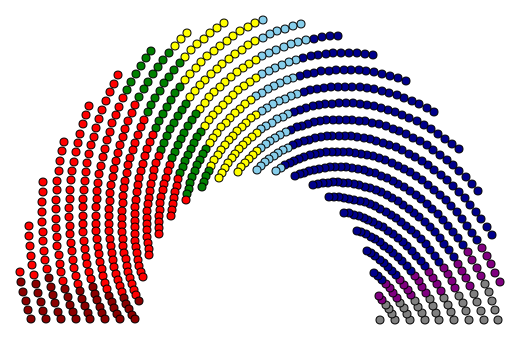

In [15]:
image = svg_graph(position=circle[:839],node_size=node_size, labels=labels,  width=width, height=height, label_colors=label_colors)
SVG(image)

# Biadjacency  graphs

In [16]:
graph_for = from_edge_list(edge_list_for, bipartite=True)
graph_against = from_edge_list(edge_list_absent, bipartite=True)
graph_absent = from_edge_list(edge_list_against, bipartite=True)


biadjacency_for = graph_for.biadjacency
biadjacency_against = graph_against.biadjacency
biadjacency_absent = graph_absent.biadjacency
names = allvotes['names'].values
names_row = graph_for.names_row
names_col = graph_for.names_col

# Clustering & Hierarchy

First, we want to cluster our MP with the same number of cluster as the number of political groups to see if their vote at the parliament can cluster them in the same groups. To know if the algorithm is efficient we must compare the different groups. 

The algorithms implemented here are Louvain for the clustering part and PageRank concerning hierarchy

In [17]:
n_restrict_bill = 15
n_restrict_mp = 50
names_row_restricted = graph_for.names_row[:n_restrict_bill]
names_col_restricted = graph_for.names_col[:n_restrict_mp]
biadjacency_for_restricted = biadjacency_for[:n_restrict_bill,:n_restrict_mp]
biadjacency_against_restricted = biadjacency_against[:n_restrict_bill,:n_restrict_mp]
biadjacency_absent_restricted = biadjacency_absent[:n_restrict_bill,:n_restrict_mp]

We call the Louvain function with a resolution of 1.09. The parameter was chosen by trial and error, we reduced it when it gave us too many clusters and augmented it when it didn't find enough clusters

In [18]:
louvain = Louvain(1.09)
pagerank = PageRank()

In [19]:
louvain.fit(biadjacency_for)
labels_row = louvain.labels_row_
labels_col = louvain.labels_col_
labels_row_restricted = louvain.labels_row_[:n_restrict_bill]
labels_col_restricted = louvain.labels_col_[:n_restrict_mp]

Here we show the bipartite graph between laws and deputies, with each color representing a cluster. However this method isn't very readable since each law is heavily linked to many deputies. 
We tried reducing the dataset with restrictions but it was not that relevant

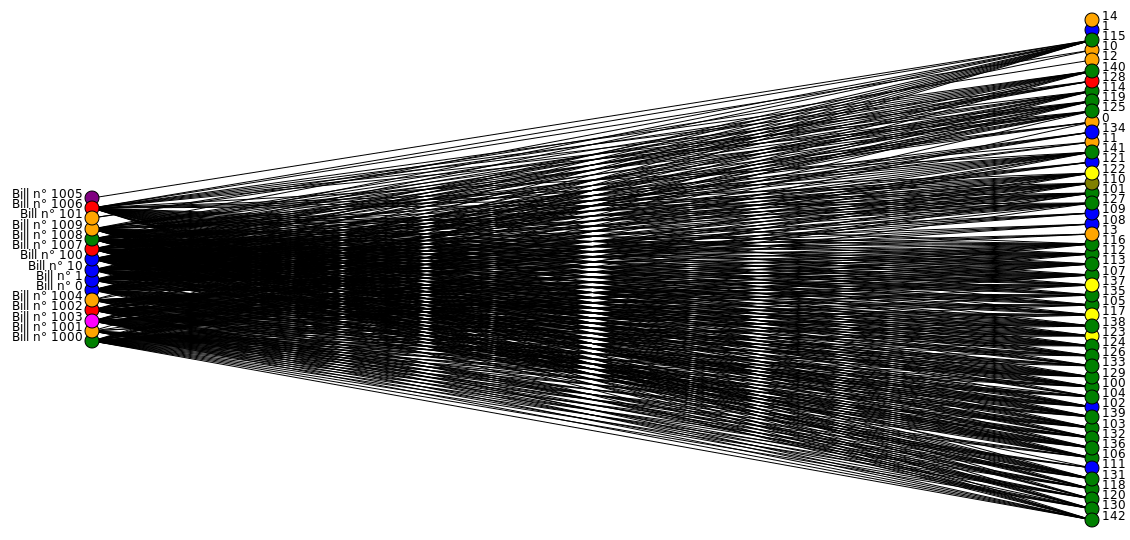

In [20]:
width = 1000
height = 500
image = svg_bigraph(biadjacency_for_restricted, names_row_restricted, names_col_restricted, labels_row_restricted, labels_col_restricted, width=width, height=height)
SVG(image)

Here is the same graph but designed as a semicircle. Each point is the same deputy as before but the colors changed according to the clusters Louvain found. 
Unlike the bipartite graph, the results are much more readable. We can see Louvain managed to reproduce roughly most political parties of the assembly. 

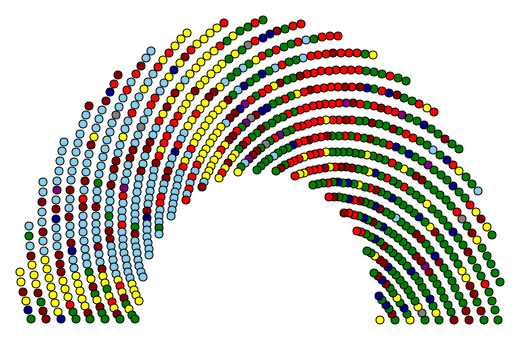

In [21]:
n = len(labels_col)
width = 480
height = 300
image = svg_graph(position=circle[:n],node_size=node_size, labels=labels_col,  width=width, height=height, label_colors=label_colors)
SVG(image)

We compute the most important points to each cluster thanks to PageRank, it means the most important MP and most important law. 

For instance, we may want to see the total number of deputies from every cluster for each political group

In [22]:
def political_cluster(labels_louvain, cluster_number):
  dico = {
    'ALDE/ADLE': 0,
    'ECR': 0,
    'EFD': 0,
    'EPP': 0,
    'GUE-NGL' : 0,
    'S&D' : 0,
    'Greens/EFA' : 0,
    'NI' : 0
}
  for i,elt in enumerate(labels_louvain):
    if elt == cluster_number:
      dico[allvotes.iloc[i]['political_group']] += 1
  return dico 

political_group_in_cluster  = [political_cluster(labels_col, i) for i in range(len(np.unique(labels_col)))]
for i in range(len(np.unique(labels_col))):
  print(political_group_in_cluster[i])

{'ALDE/ADLE': 14, 'ECR': 4, 'EFD': 4, 'EPP': 39, 'GUE-NGL': 9, 'S&D': 34, 'Greens/EFA': 4, 'NI': 6}
{'ALDE/ADLE': 10, 'ECR': 11, 'EFD': 0, 'EPP': 80, 'GUE-NGL': 2, 'S&D': 10, 'Greens/EFA': 18, 'NI': 1}
{'ALDE/ADLE': 16, 'ECR': 29, 'EFD': 27, 'EPP': 127, 'GUE-NGL': 12, 'S&D': 7, 'Greens/EFA': 0, 'NI': 19}
{'ALDE/ADLE': 42, 'ECR': 2, 'EFD': 3, 'EPP': 19, 'GUE-NGL': 18, 'S&D': 18, 'Greens/EFA': 21, 'NI': 4}
{'ALDE/ADLE': 6, 'ECR': 3, 'EFD': 0, 'EPP': 4, 'GUE-NGL': 0, 'S&D': 137, 'Greens/EFA': 20, 'NI': 0}
{'ALDE/ADLE': 2, 'ECR': 5, 'EFD': 1, 'EPP': 23, 'GUE-NGL': 2, 'S&D': 4, 'Greens/EFA': 2, 'NI': 3}
{'ALDE/ADLE': 3, 'ECR': 1, 'EFD': 0, 'EPP': 4, 'GUE-NGL': 0, 'S&D': 2, 'Greens/EFA': 0, 'NI': 0}
{'ALDE/ADLE': 2, 'ECR': 1, 'EFD': 0, 'EPP': 1, 'GUE-NGL': 0, 'S&D': 2, 'Greens/EFA': 0, 'NI': 1}


Or we can display the subject of preference of each cluster, here we show the 5 most important laws, the 5 most important deputies according to PageRank. 

We also print the parties these deputies are members of, the total for each political party inside the cluster and the law categories

In [23]:
top_pages = []
for label in np.unique(labels_row)[:10]:
    pagerank.fit(biadjacency_for, seeds_row=labels_row==label, seeds_col=labels_col==label)
    scores_row_ = pagerank.scores_row_ * (labels_row==label)
    scores_col_ = pagerank.scores_col_ * (labels_col==label)
    print("---------------------------Cluster " + str(label) + "---------------------------")
    bills = np.array(column_modif)[top_k(scores_row_, 5)]
    bills = [int(bills[i][:-4]) for i in range(len(bills))]
    print(laws['Name of document'][bills])
    people = names[top_k(scores_col_, 5)]
    print(people)
    result = [allvotes[allvotes['names'] == people[i]]['political_group'].values[0] for i in range(5)]
    print(result)
    top_pages.append(np.argmax(scores_col_))
    law_field = [laws['Policy area'].iloc[i] for i in bills]
    print(political_group_in_cluster[label])
    print(law_field)

---------------------------Cluster 0---------------------------
1206    Specific measures for agriculture in the outer...
1017    Mobilisation of the European Globalisation Adj...
972     A financing instrument for development coopera...
1061    EU external strategy on Passenger Name Record ...
59      Mobilisation of the EU Solidarity Fund: floodi...
Name: Name of document, dtype: object
['Karl-Heinz FLORENZ' 'Werner LANGEN' 'Claude MORAES'
 'José Manuel FERNANDES' 'Eleni THEOCHAROUS']
['EPP', 'EPP', 'S&D', 'EPP', 'EPP']
{'ALDE/ADLE': 14, 'ECR': 4, 'EFD': 4, 'EPP': 39, 'GUE-NGL': 9, 'S&D': 34, 'Greens/EFA': 4, 'NI': 6}
['Agriculture', 'Budget', 'Development', 'Civil liberties, justice & home affairs', 'Budget']
---------------------------Cluster 1---------------------------
467    Cases of impunity in the Philippines - Joint m...
453    2013 budget - mandate for trilogue - Motion fo...
161    Community Customs Code as regards the date of ...
411    Agricultural product quality schemes

# Louvain and PageRank Result commentary :



In cluster 0 \
PageRank identifies 4 deputies from EPP out of 5 as the most important deputies of the cluster. This is coherent with EPP having the majority within this cluster. 
Without surprise, the main laws in a cluster with a majority of right-wing deputies are about budget, development and agriculture. \
In cluster 1 \
Again, 4 deputies out of 5 are from EPP, with a majority of 80 deputies. And we find more law categories appreciated by right-wing parties in the most important laws of the cluster : foreign & security policy, budget, agriculture… \
In cluster 3 \
Here the most represented parties are the Greens/EFA and ALDE/ADLE. This majority is found again with the 5 most important deputies of the clusters, coming exclusively from these two parties.
The laws that are selected also seem to be coherent with that. Indeed, it is quite logical to see a centrist party and an ecology party voting for laws regarding transport, tourism and energy.
In cluster 4 \
We see again the Greens/EFA party coming up with this cluster alongside S&D, which is an even more common duo than the previous one. 
Some ecological matters are again found in the main laws of the cluster such as Fisheries and social themes like justice, home affairs and civil liberties. Social laws are more represented since S&D holds a significant majority of 137 deputies in this cluster. \
In cluster 5 \
Back to EPP with this cluster with a small majority of 23 deputies, industrial laws, economic and monetary affairs, foreign and security policies are the main subjects in this cluster. Once again, the cluster reflects the main idea of its majority of deputies. \
Cluster 6 and 7 are too small to be worth analyzing. That said, it shows that there is still a margin of improvement regarding the clustering part.

In [24]:
n_political_party = 8
louvain_hierarchy = LouvainHierarchy()
louvain_hierarchy.fit(biadjacency_for)
dendrogram_row = louvain_hierarchy.dendrogram_row_
dendrogram_col = louvain_hierarchy.dendrogram_col_
dendrogram_full = louvain_hierarchy.dendrogram_full_

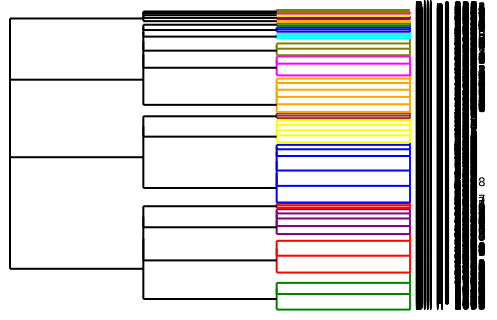

In [25]:
height = 5000
width = 500
image = svg_dendrogram(dendrogram_row, names_row, n_clusters=n_political_party, rotate=True)
SVG(image)

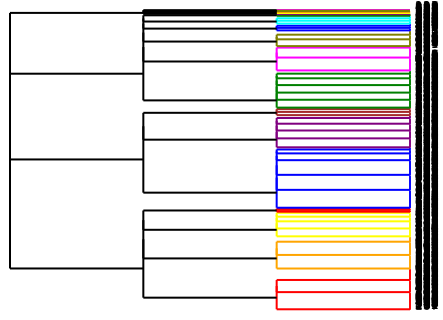

In [26]:
image = svg_dendrogram(dendrogram_col, names_col, n_clusters=n_political_party, rotate=True)
SVG(image)

As there is too much data to visualize, we won't show the cluster of the bills but we will show the cluster of the MP that we have. 

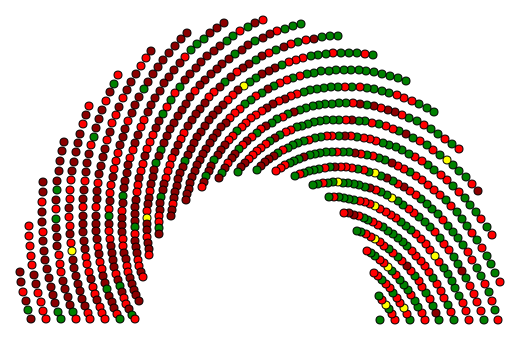

In [27]:
labels_col = cut_straight(dendrogram_col)
n = len(labels_col)
width = 480
height = 300
image = svg_graph(position=circle[:n],node_size=node_size, labels=labels_col,  width=width, height=height, label_colors=label_colors)
SVG(image)

The hierarchical Louvin algorithm allows to visually divide the assembly into left and right without being more precise about the different parties.

# Diffusion

For diffusion we must transpose our rows and our columns.  

In [28]:
edge_list_for = []
edge_list_absent = []
edge_list_against = []
n,m = a_modif.shape
count = 0
for j,c in enumerate(column_modif):
    for i,index in enumerate(a_modif[c] == 'Absent'):
        if index:
            edge_list_absent.append((i,"Bill n° " + str(j)))
    for i,index in enumerate(a_modif[c] == 'For'):
        if index:
            edge_list_for.append((i,"Bill n° " + str(j)))
    for i,index in enumerate(a_modif[c] == 'Didn\'t vote'):
        if index :
            edge_list_absent.append((i,"Bill n° " + str(j)))
    for i,index in enumerate(a_modif[c] == 'Against'):
        if index :
            edge_list_against.append((i,"Bill n° " + str(j)))
    for i,index in enumerate(a_modif[c] == 'NUL'):
        if index :
            edge_list_absent.append((i,"Bill n° " + str(j)))
graph_for = from_edge_list(edge_list_for, bipartite=True)
graph_against = from_edge_list(edge_list_absent, bipartite=True)
graph_absent = from_edge_list(edge_list_against, bipartite=True)


biadjacency_for = graph_for.biadjacency
biadjacency_against = graph_against.biadjacency
biadjacency_absent = graph_absent.biadjacency
names = allvotes['names'].values

In [29]:
gue= np.isin(labels, [0])
left =  np.isin(labels, [1])
green =  np.isin(labels, [2])
center =  np.isin(labels, [3])
mid_right =  np.isin(labels, [4])
right =  np.isin(labels, [5])
far_right  =  np.isin(labels, [6])
ni =  np.isin(labels, [7])

We defined the political party as before to create seed rows depending on the political party for diffusion algorithm

In [30]:
def create_seed_rows (hot_pot, cold_pot, n_seeds= 1000):
  seeds_row =  {}
  count_hot = 0
  count_cold = 0
  for i in range(839):
    if (hot_pot[i] and (count_hot< n_seeds)):
      count_hot += 1
      seeds_row[i] = 1
    if (cold_pot[i] and (count_cold< n_seeds)):
      count_cold += 1
      seeds_row[i] = 0
  return seeds_row

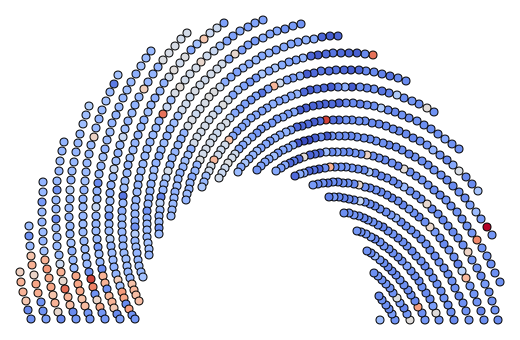

In [31]:
diffusion = Diffusion(n_iter=4)

values = diffusion.fit_transform(biadjacency_for, seeds_row=create_seed_rows(gue,right))

image = svg_graph(position=circle[:839], scores=values, node_size=node_size,
                  width=width, height=height)
SVG(image)

Here we can observed the diffusion when we put the hot spot on the gue (far-left) party and the cold spot on the right wing.\ 
This chart emphasizes that the green are the closest to the gue party and are also close to the right. The Left party Social Democrats ares closer to the righ than the far-left.\
You can also observe some MP close to the right in the far-left, that's because they are eurosceptic

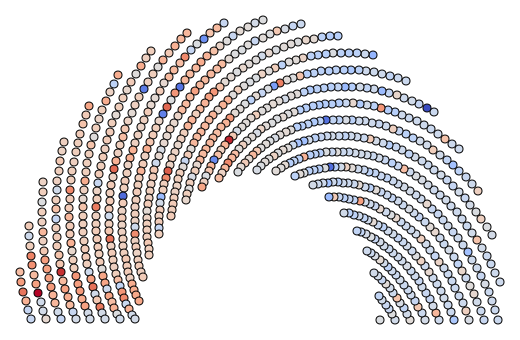

In [32]:

diffusion = Diffusion(n_iter=4)

values = diffusion.fit_transform(biadjacency_for, seeds_row=create_seed_rows(left,right, n_seeds = 150))

image = svg_graph(position=circle[:839], scores=values, node_size=node_size,
                  width=width, height=height)
SVG(image)

Here we can observed the diffusion when we put the hot spot on the left party and the cold spot on the right wing.\
The colours are duller in the center because they do a lot of agreement to vote for each other as soon as anyone doesn't have a clear majority.\
Nevertheless you can clearly see the left and the right wing in this chart.


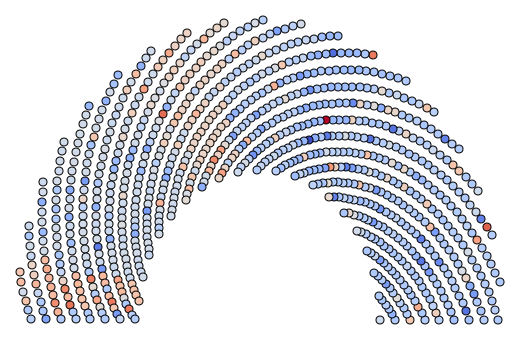

In [33]:
diffusion = Diffusion(n_iter=4)

values = diffusion.fit_transform(biadjacency_for, seeds_row=create_seed_rows(green, mid_right))

image = svg_graph(position=circle[:839], scores=values, node_size=node_size,
                  width=width, height=height)
SVG(image)

Finally we can observed the diffusion when we put the hot spot on the green party and the cold spot on the right wing.\
The SD are more blue because they more often vote with the mid RIGHT( EPP and ALDE).\
The far_left the GUE party seems to be the unique party only close to the green. They don't have any other friend. It is kind of a political alliance.


For diffusion we now use the Dirichelet classifier algorithm.

In [34]:
from sknetwork.classification import DirichletClassifier

In [35]:
dirichlet = DirichletClassifier()
dirichlet.fit(biadjacency_for, create_seed_rows(green,right))
labels_row = dirichlet.labels_row_
labels_col = dirichlet.labels_col_
# soft classification (here probability of label 1)
membership_row = dirichlet.membership_row_
membership_col = dirichlet.membership_col_

scores_row = membership_row[:,1].toarray().ravel()
scores_col = membership_col[:,1].toarray().ravel()



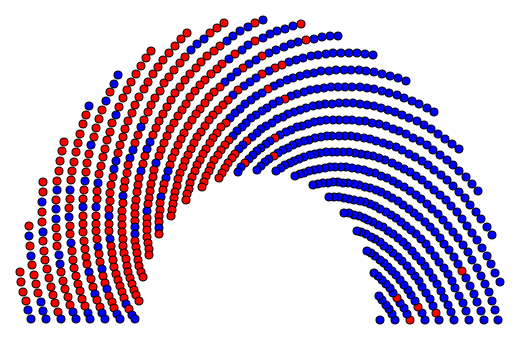

In [36]:
image = svg_graph( position=circle[:839],node_size=node_size,scores = scores_row, labels=labels_row,  width=width, height=height)
SVG(image)

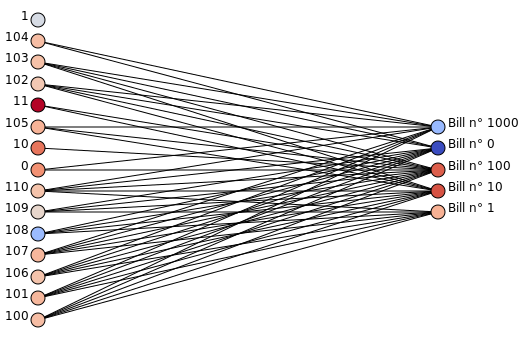

In [37]:
n_restrict_bill = 15
n_restrict_mp = 5
names_row= graph_for.names_row[:n_restrict_bill]
names_col = graph_for.names_col[:n_restrict_mp]
biadjacency_for_restricted = biadjacency_for[:n_restrict_bill,:n_restrict_mp]
scores_row_r = membership_row[:,1].toarray().ravel()[:n_restrict_bill]
scores_col_r = membership_col[:,1].toarray().ravel()[:n_restrict_mp]
image = svg_bigraph(biadjacency_for_restricted, names_row, names_col, scores_row=scores_row_r, scores_col=scores_col_r,
                    )
SVG(image)

With the dirichlet algorithm by placing the hot_spot in the green party and the cold spot in the EPP (right party) we find a classic left-right distribution with progressives and conservatives.\
To sum up the diffusion and dirichlet algorithm are pretty efficient to find the political parties.

# Embedding




In this part we will first do spectral embedding and then test the PCA embedding using principal components analysis

In [38]:
edge_list_for = []
edge_list_absent = []
edge_list_against = []
n,m = a_modif.shape
count = 0
for j,c in enumerate(column_modif):
    for i,index in enumerate(a_modif[c] == 'Absent'):
        if index:
            edge_list_absent.append((i,"Bill n° " + str(j)))
    for i,index in enumerate(a_modif[c] == 'For'):
        if index:
            edge_list_for.append((i,"Bill n° " + str(j)))
    for i,index in enumerate(a_modif[c] == 'Didn\'t vote'):
        if index :
            edge_list_absent.append((i,"Bill n° " + str(j)))
    for i,index in enumerate(a_modif[c] == 'Against'):
        if index :
            edge_list_against.append((i,"Bill n° " + str(j)))
    for i,index in enumerate(a_modif[c] == 'NUL'):
        if index :
            edge_list_absent.append((i,"Bill n° " + str(j)))
    

In [39]:
graph_for = from_edge_list(edge_list_for, bipartite=True)
graph_against = from_edge_list(edge_list_absent, bipartite=True)
graph_absent = from_edge_list(edge_list_against, bipartite=True)


biadjacency_for = graph_for.biadjacency
biadjacency_against = graph_against.biadjacency
biadjacency_absent = graph_absent.biadjacency
names = allvotes['names'].values

In [40]:
spectral2 = Spectral(2, normalized=False)
embedding2d = spectral2.fit_transform(biadjacency_for)


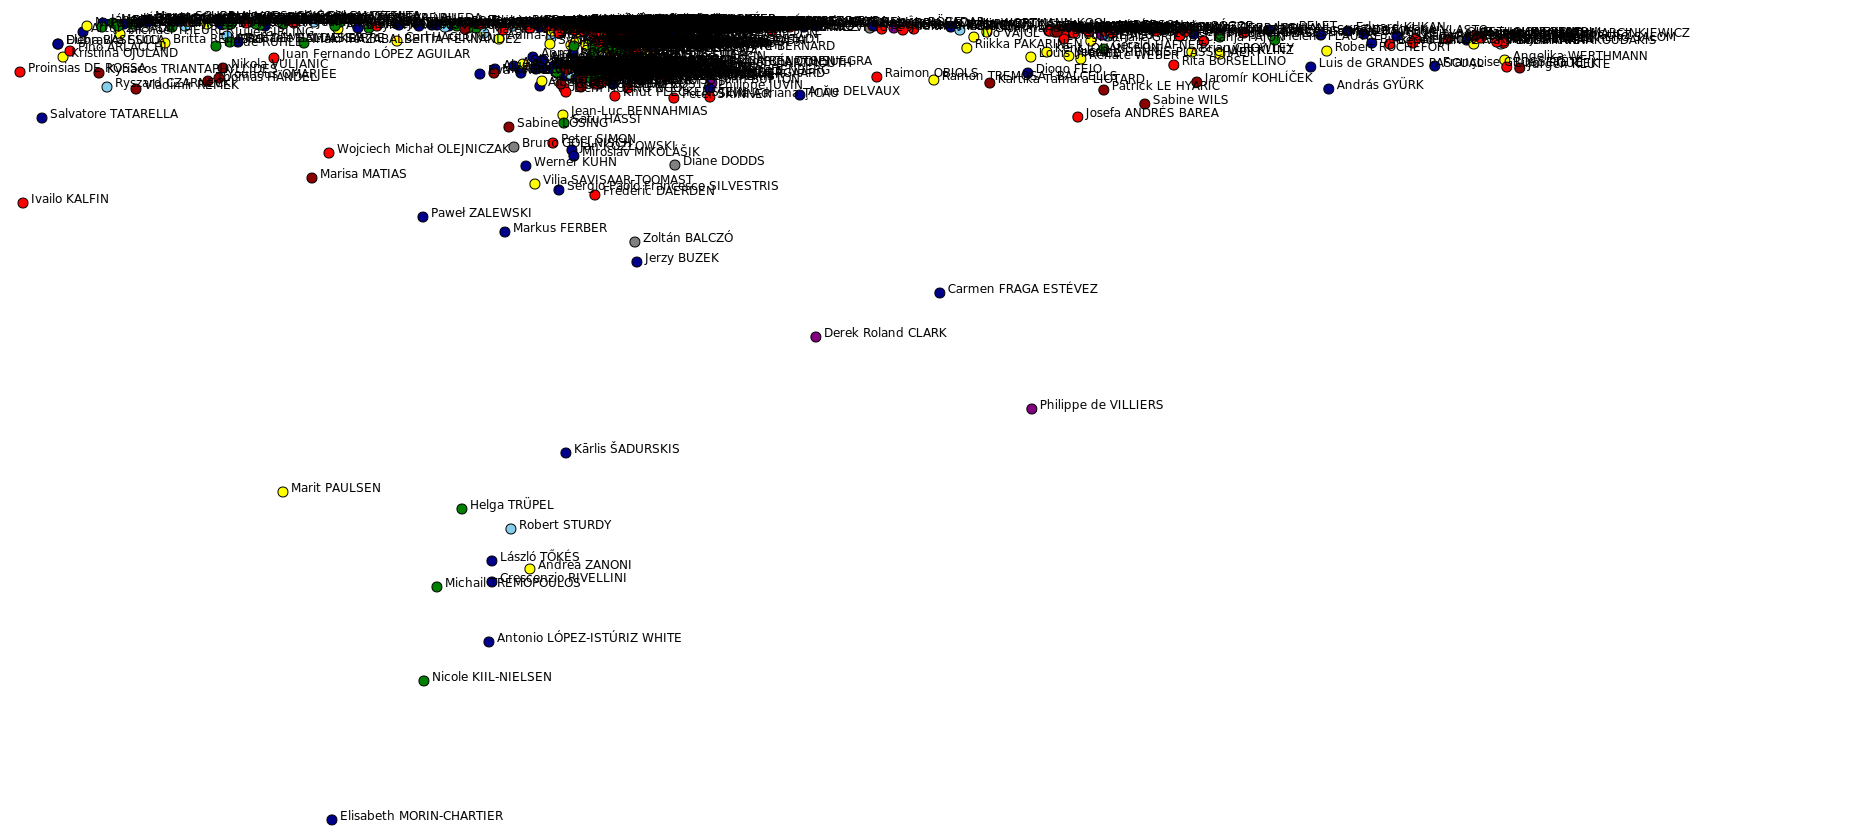

In [41]:
image = svg_graph(position=embedding2d, names=names, labels=labels, node_size=5, width=1500, height=800,label_colors=label_colors)
SVG(image)

This graph is not totally relevant because most of the MP's are stock in the bottom. Nevertheless this graphs highlights some exceptions.\
As an example it is quite understandable to find Elizabeth Morin Chartier at the top alone because she was at that time the quaestor of the European parliament.

We will now plot the restriction of this graph to some political parties.

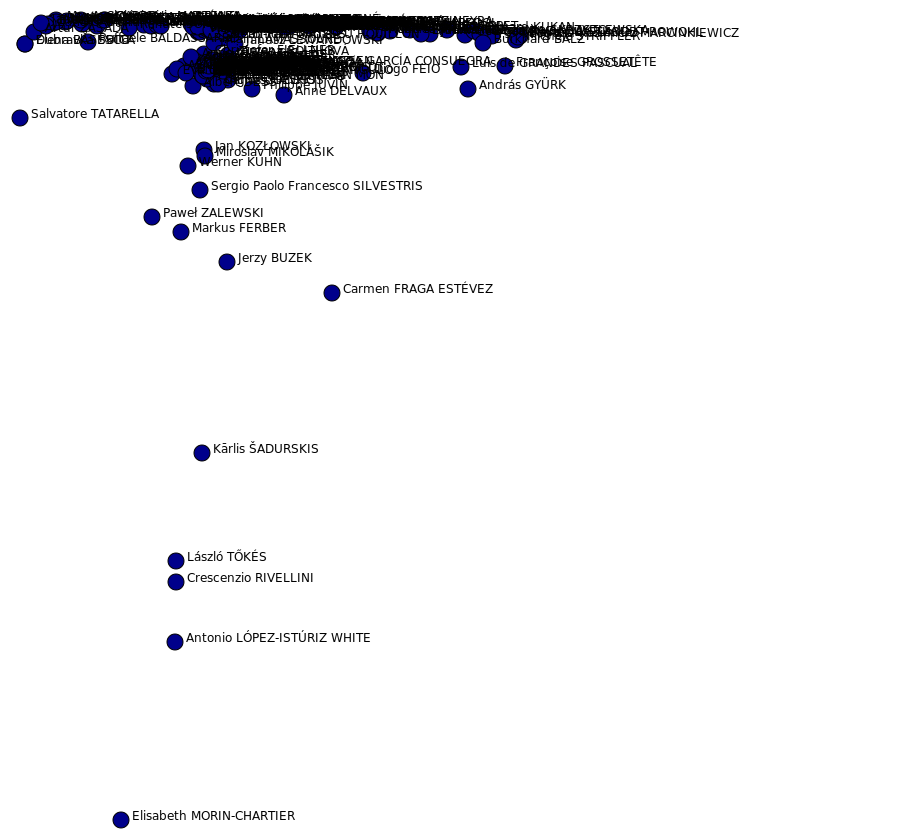

In [42]:
image = svg_graph(position=embedding2d[right],names = names[right], labels=np.array(labels)[right], node_size=8, width=500, height=800,label_colors=label_colors)
SVG(image)

As expected Elisabeth Morin-Chartier is far away from her colleagues.

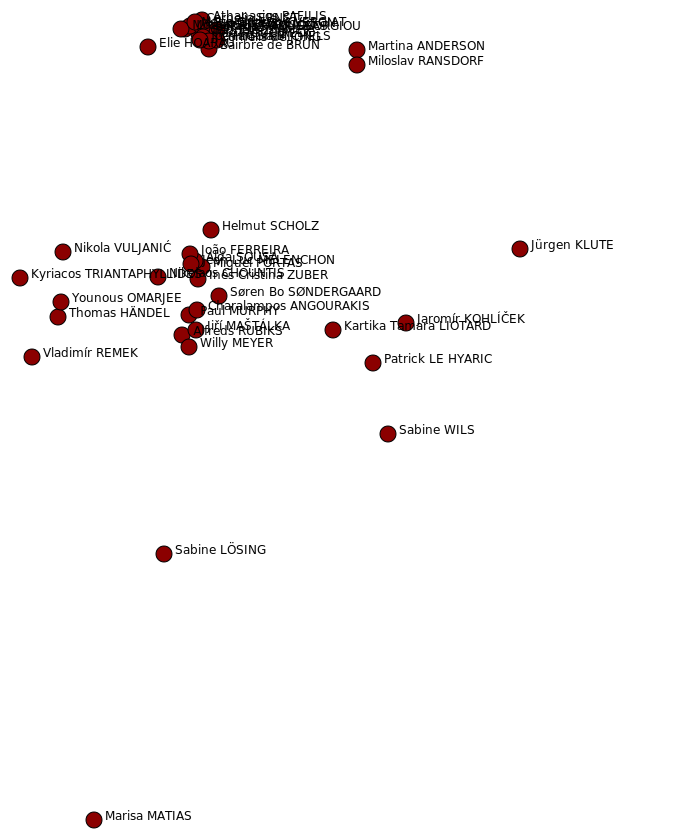

In [43]:
image = svg_graph(position=embedding2d[gue],names = names[gue], labels=np.array(labels)[gue], node_size=8, width=500, height=800,label_colors=label_colors)
SVG(image)

At the opposite the GUE Party are relatively stock but it seems to have two different clusters.

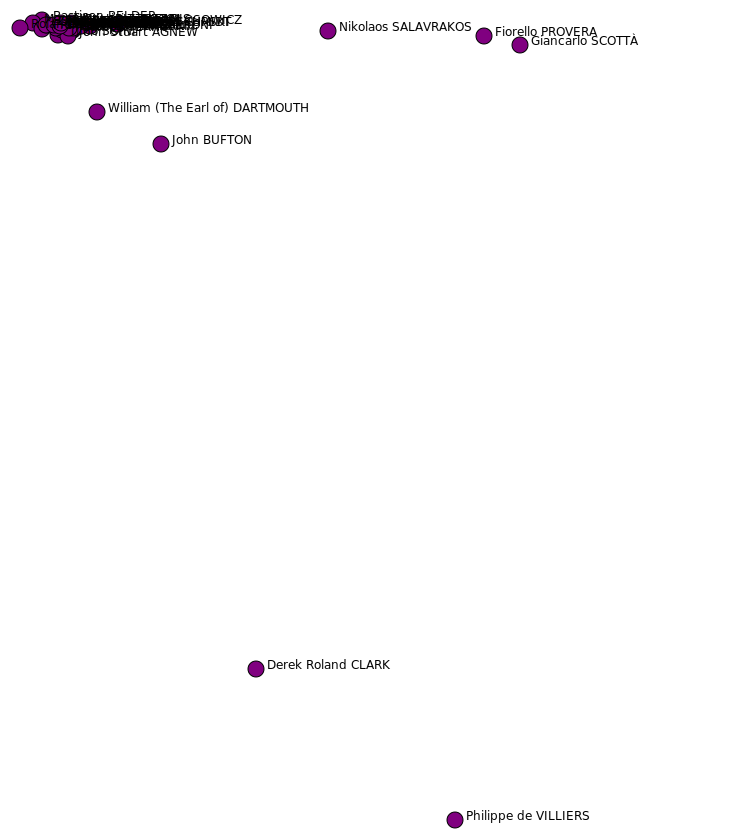

In [44]:
image = svg_graph(position=embedding2d[far_right],names = names[far_right], labels=np.array(labels)[far_right], node_size=8, width=500, height=800,label_colors=label_colors)
SVG(image)

Finally for the far right party, Phillipe de Villier is alone, it can be explained by the fact that it was the only french in this political party. Maybe he didn't agree with his colleagues on most of the things bt chose to sit with them to have a bigger impact.

In [45]:
from sknetwork.embedding import PCA
pca = PCA()
embeddingpca = pca.fit_transform(biadjacency_for)
embeddingpca.shape

(839, 2)

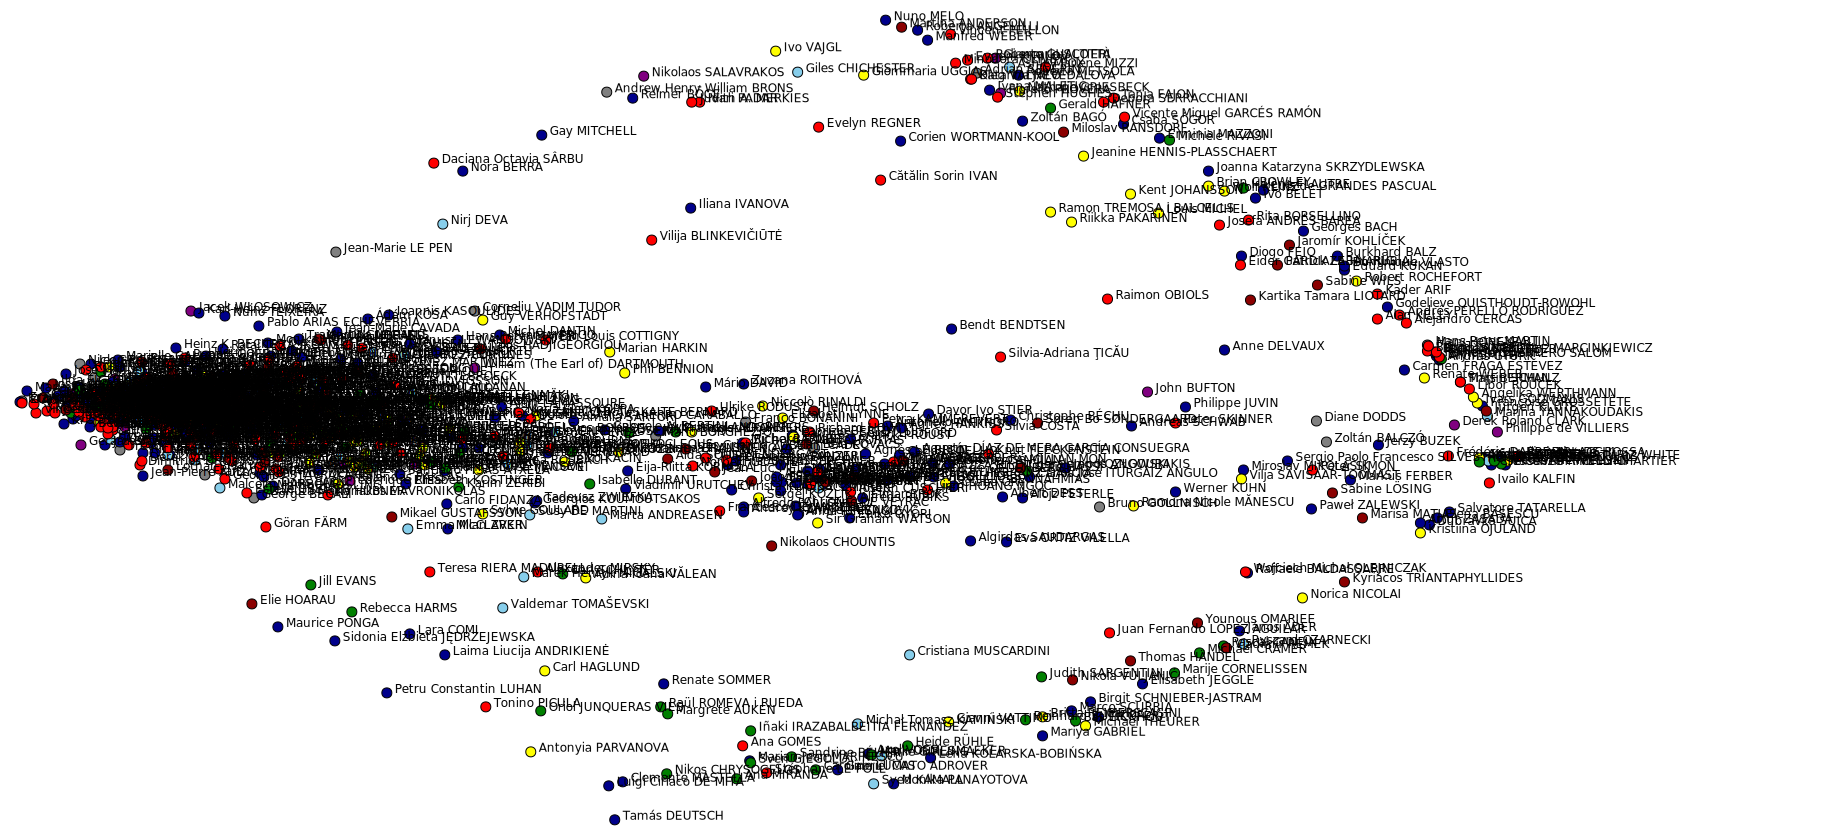

In [46]:
image = svg_graph(position=embeddingpca, names=names, labels=labels, node_size=5, width=1500, height=800,label_colors=label_colors)
SVG(image)

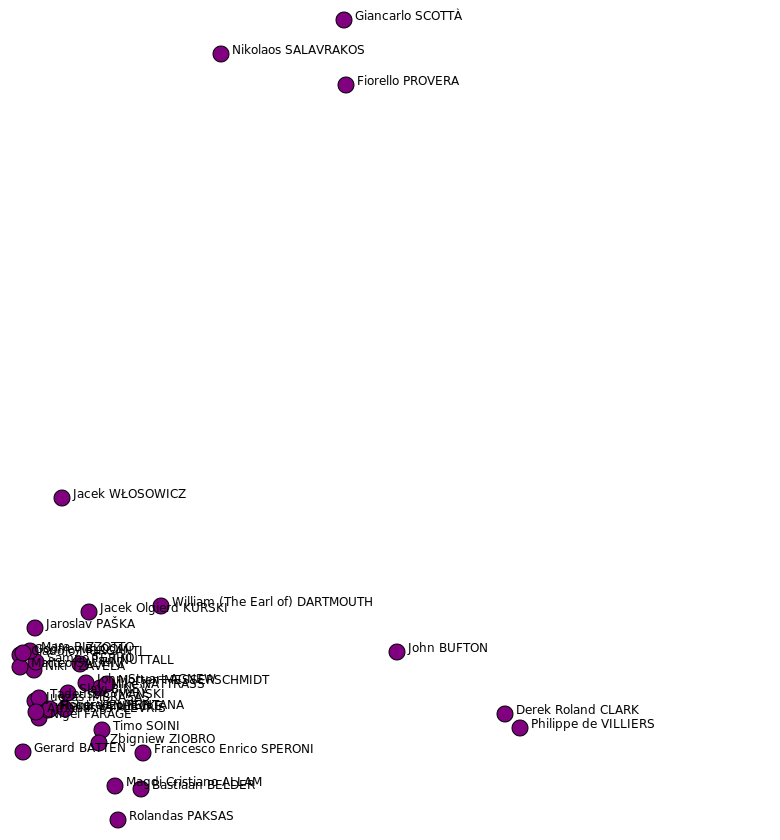

In [47]:
image = svg_graph(position=embeddingpca[far_right],names = names[far_right], labels=np.array(labels)[far_right], node_size=8, width=500, height=800,label_colors=label_colors)
SVG(image)

The results are not convincing with the pca algorithm.

# Against & Absenteism 

In [55]:
edge_list_for = []
edge_list_absent = []
edge_list_against = []
n,m = a_modif.shape
count = 0
for j,c in enumerate(column_modif):
    for i,index in enumerate(a_modif[c] == 'Absent'):
        if index:
            edge_list_absent.append(("Bill n° " + str(j),i))
    for i,index in enumerate(a_modif[c] == 'For'):
        if index:
            edge_list_for.append(("Bill n° " + str(j),i))
    for i,index in enumerate(a_modif[c] == 'Didn\'t vote'):
        if index :
            edge_list_absent.append(("Bill n° " + str(j),i))
    for i,index in enumerate(a_modif[c] == 'Against'):
        if index :
            edge_list_against.append(("Bill n° " + str(j),i))

In [56]:
graph_for = from_edge_list(edge_list_for, bipartite=True)
graph_against = from_edge_list(edge_list_absent, bipartite=True)
graph_absent = from_edge_list(edge_list_against, bipartite=True)


biadjacency_for = graph_for.biadjacency
biadjacency_against = graph_against.biadjacency
biadjacency_absent = graph_absent.biadjacency
names = allvotes['names'].values
names_row = graph_for.names_row
names_col = graph_for.names_col

In [57]:
n_restrict_bill = 15
n_restrict_mp = 50
names_row_restricted = graph_for.names_row[:n_restrict_bill]
names_col_restricted = graph_for.names_col[:n_restrict_mp]
biadjacency_for_restricted = biadjacency_for[:n_restrict_bill,:n_restrict_mp]
biadjacency_against_restricted = biadjacency_against[:n_restrict_bill,:n_restrict_mp]
biadjacency_absent_restricted = biadjacency_absent[:n_restrict_bill,:n_restrict_mp]

In [58]:
louvain = Louvain(0.9)
louvain.fit(biadjacency_against)
labels_row = louvain.labels_row_
labels_col = louvain.labels_col_
labels_row_restricted = louvain.labels_row_[:n_restrict_bill]
labels_col_restricted = louvain.labels_col_[:n_restrict_mp]

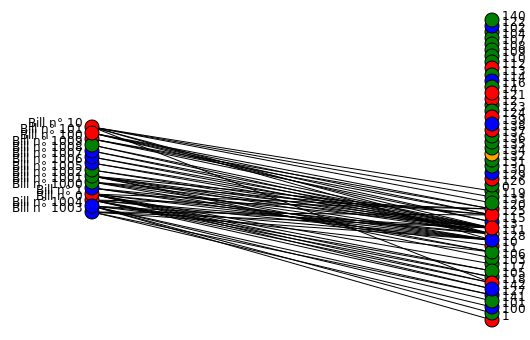

In [59]:
width = 1000
height = 500
image = svg_bigraph(biadjacency_against_restricted, names_row, names_col, labels_row_restricted, labels_col_restricted)
SVG(image)

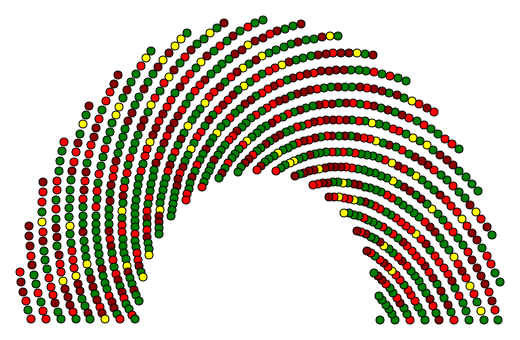

In [60]:
n = len(labels_col)
width = 480
height = 300
image = svg_graph(position=circle[:n],node_size=node_size, labels=labels_col,  width=width, height=height, label_colors=label_colors)
SVG(image)

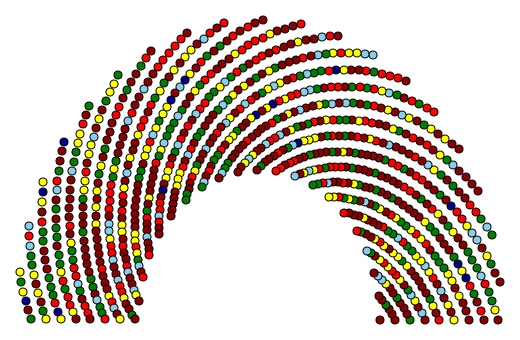

In [61]:
louvain_hierarchy = LouvainHierarchy()
louvain_hierarchy.fit(biadjacency_against)
dendrogram_row = louvain_hierarchy.dendrogram_row_
dendrogram_col = louvain_hierarchy.dendrogram_col_
dendrogram_full = louvain_hierarchy.dendrogram_full_
labels_col = cut_straight(dendrogram_col)
n = len(labels_col)
width = 480
height = 300
image = svg_graph(position=circle[:n],node_size=node_size, labels=labels_col,  width=width, height=height, label_colors=label_colors)
SVG(image)

It was a bit predictable but there isn’t much to conclude in this part. The clustering looks a bit random, which is logical since deputies who disagree with the same ideas do not necessarily share the same ideas

In [62]:
louvain.fit(biadjacency_absent)
labels_row = louvain.labels_row_
labels_col = louvain.labels_col_
labels_row_restricted = louvain.labels_row_[:n_restrict_bill]
labels_col_restricted = louvain.labels_col_[:n_restrict_mp]

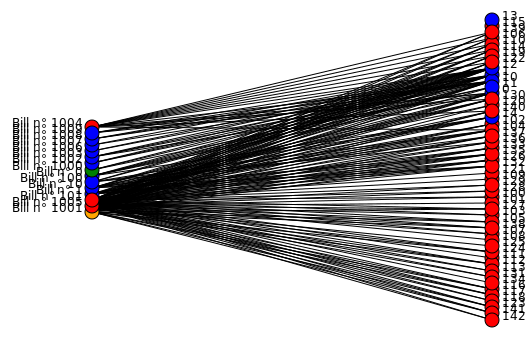

In [63]:
width = 1000
height = 500
image = svg_bigraph(biadjacency_absent_restricted, names_row, names_col, labels_row_restricted, labels_col_restricted)
SVG(image)

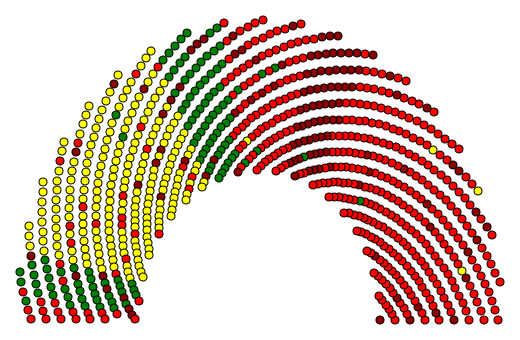

In [64]:
n = len(labels_col)
width = 480
height = 300
image = svg_graph(position=circle[:n],node_size=node_size, labels=labels_col,  width=width, height=height, label_colors=label_colors)
SVG(image)

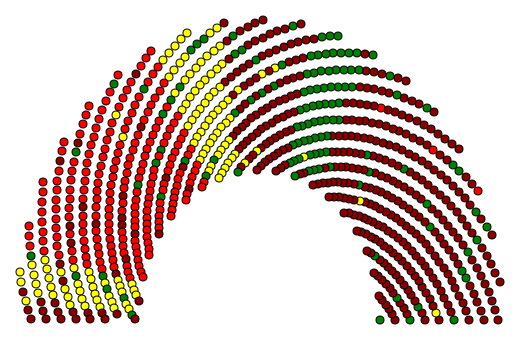

In [65]:
louvain_hierarchy = LouvainHierarchy()
louvain_hierarchy.fit(biadjacency_absent)
dendrogram_row = louvain_hierarchy.dendrogram_row_
dendrogram_col = louvain_hierarchy.dendrogram_col_
dendrogram_full = louvain_hierarchy.dendrogram_full_
labels_col = cut_straight(dendrogram_col)
n = len(labels_col)
width = 480
height = 300
image = svg_graph(position=circle[:n],node_size=node_size, labels=labels_col,  width=width, height=height, label_colors=label_colors)
SVG(image)

Louvain and Hierarchical Leuven have good results on abstention and even allow to divide the assembly according to the original parties.

In [68]:
edge_list_for = []
edge_list_absent = []
edge_list_against = []
n,m = a_modif.shape
count = 0
for j,c in enumerate(column_modif):
    for i,index in enumerate(a_modif[c] == 'Absent'):
        if index:
            edge_list_absent.append((i,"Bill n° " + str(j)))
    for i,index in enumerate(a_modif[c] == 'For'):
        if index:
            edge_list_for.append((i,"Bill n° " + str(j)))
    for i,index in enumerate(a_modif[c] == 'Didn\'t vote'):
        if index :
            edge_list_absent.append((i,"Bill n° " + str(j)))
    for i,index in enumerate(a_modif[c] == 'Against'):
        if index :
            edge_list_against.append((i,"Bill n° " + str(j)))
    for i,index in enumerate(a_modif[c] == 'NUL'):
        if index :
            edge_list_absent.append((i,"Bill n° " + str(j)))

In [69]:
graph_for = from_edge_list(edge_list_for, bipartite=True)
graph_against = from_edge_list(edge_list_absent, bipartite=True)
graph_absent = from_edge_list(edge_list_against, bipartite=True)


biadjacency_for = graph_for.biadjacency
biadjacency_against = graph_against.biadjacency
biadjacency_absent = graph_absent.biadjacency
names = allvotes['names'].values
names_row = graph_for.names_row
names_col = graph_for.names_col

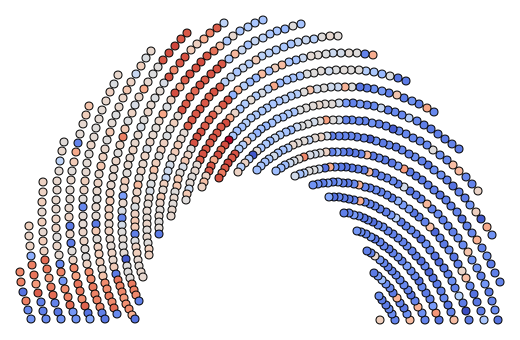

In [70]:
diffusion = Diffusion(n_iter=4)

values = diffusion.fit_transform(biadjacency_absent, seeds_row=create_seed_rows(green, far_right))

image = svg_graph(position=circle[:838], scores=values, node_size=node_size,
                  width=width, height=height)
SVG(image)

In the same way, the distribution of absenteeism makes it possible to classify the members of the assembly by party.

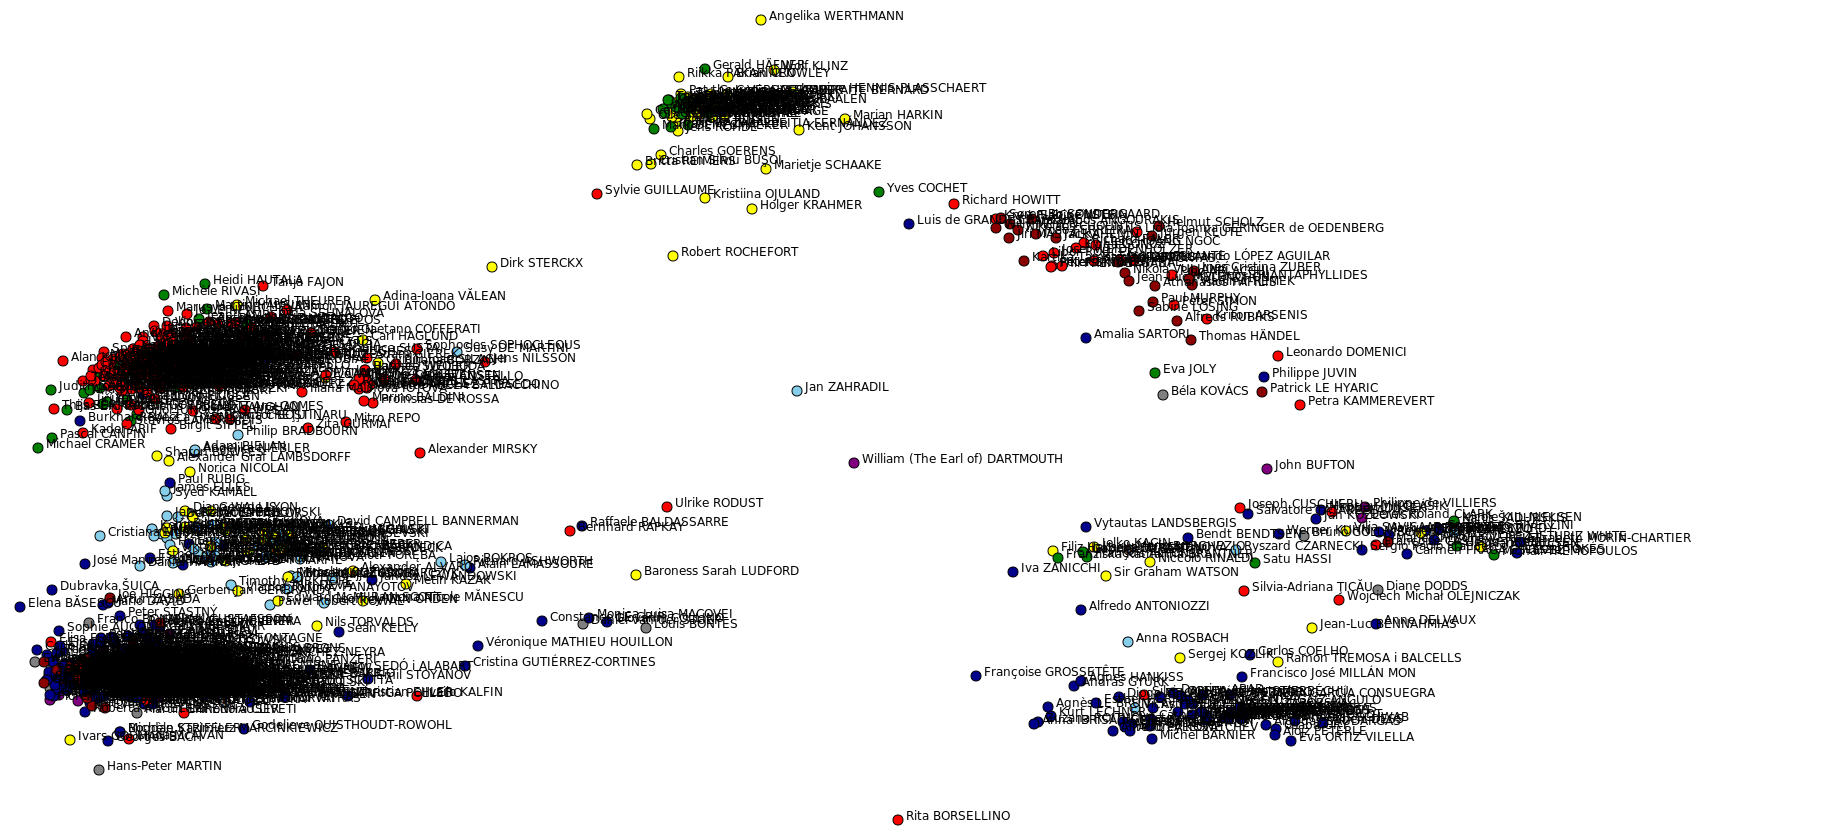

In [71]:
spectral2 = Spectral(2, normalized=False)
embedding2d = spectral2.fit_transform(biadjacency_absent)
image = svg_graph(position=embedding2d, names=names[:838], labels=labels[:838], node_size=5, width=1500, height=800,label_colors=label_colors)
SVG(image)

The absenteeism on embedding allows for a good representation of the deputies in a plan. Members of the same party are in the same place.
Both Leuven and Leuven Hierarchical have good results in finding groups based on absenteeism. As we have also taken the option "Did not vote" into account in the absenteeism we can say that in the same part people pass the word not to vote for a law that does not concern them. 



# Conclusion of our analysis

The European assembly is different from the French assembly in the sense that the laws that are voted on are only the final bills passed and not all the laws for which a consensus has been found beforehand which is less polarizing. 


We also have that MPs can have national interests, so that people from different parties can converge on certain votes, which can explain that clusters are not totally limited to parties and that politically distant MPs come together here.  

We always have the far-left that are clustered with the far-right. We may have this result because both of them are the most eurosceptics.

Some interests can be very specific like fishing and agriculture, here the constituency of origin and the country of origin counts more than the political party.

The best results are found by abstentionism and on the fact that the deputies do not vote. One can therefore assume that members of the same party boycott the same laws.

Embedding and broadcasting allows to see the relations between parties, for example that the ecologists and the extreme left are close, while the centrists are close to the moderate ecologists and the classical left. On the other hand, the right wing bloc is more united. 

In terms of legislation, the most recurrent themes are the budget and agriculture.

\


More generally, this project allowed us to learn more about the European Parliament. The results are certainly less convincing than for a bipartisan assembly such as the French or English assembly. Our study shows the porosity between the political parties and the negotiation that is the key word in Brussels.

This study is even more interesting and should be highlighted with the legislative vote of 2022 in France, where no majority is absolute and where negotiation will have a more central place.